# Solving QUBO Problem using QAOA

## Overview

In this tutorial, we will demonstrate how to solve quadratic unconstrained binary optimization (QUBO) problems using QAOA. There is a specific application for portfolio optimization and we will introduce it in another [tutorial](https://tensorcircuit.readthedocs.io/en/latest/tutorials/portfolio_optimization.html).

## QUBO problem

### What is QUBO?

Quadratic unconstrained binary optimization (QUBO) is a type of problem that aims to optimize a quadratic objective function using binary variables. The primary goal of a QUBO problem is to determine the assignments of binary variables that minimize or maximize the quadratic objective function. These variables represent choices or decision variables that can be either selected (1) or not selected (0). The objective function captures the associated costs, benefits, or constraints related to these decisions.

From a computational perspective, solving a QUBO problem is NP-hard. This classification implies that solving the optimal solution to a QUBO instance is believed to be computationally challenging, and no known polynomial-time algorithm that can efficiently solve all QUBO problems.

However, a promising approach called Quantum Approximate Optimization Algorithm (QAOA), introduced in [this tutorial](https://tensorcircuit.readthedocs.io/en/latest/tutorials/qaoa.html), has the potential to offer significant advantages when applied to QUBO problem-solving. QAOA leverages inherent quantum parallelism and interference effects to explore the solution space more efficiently compared to classical methods. This efficiency can lead to faster and more optimal solutions. In QAOA, each qubit represents a binary variable, and the objective function is calculated as the expected value of a quantum state generated by the ansatz (a quantum circuit with parameters to be decided). The parameters in the ansatz are iteratively optimized by a classical algorithm to improve the solution quality.

### General Case

For the general QUBO case, we wish to minimize a cost function of the form

$$ 
x^T Q x
$$

where $x\in\{0,1\}^n$ and $Q\in\mathbb{R}^{n\times n}$ is a real symmetric matrix.

This function maps to an Ising Hamiltonian 

$$
\frac{1}{2}\left(\sum_{i=1}^n C_{ii} + \sum_{i<j}C_{ij}\right) I - \frac{1}{2}\sum_{i=1}^n \left(\sum_{j=1}^n C_{ij} \right)Z_i +\frac{1}{2}\sum_{i<j}C_{ij}Z_iZ_j
$$

This Hamiltonian is then represented with quantum gates and put in the cost terms of the ansatz. At the same time, the cost function is defined as the expected value of this Ising Hamiltonian.

### An example

Consider minimizing the following 2x2 QUBO objective function:

$$
\begin{pmatrix}x_1 & x_2\end{pmatrix}\begin{pmatrix}-5& -2 \\-2 & 6\end{pmatrix}\begin{pmatrix}x_1\\x_2\end{pmatrix} = -5x_1^2 -4x_1x_2 +6x_2^2
$$

Clearly, this cost function is minimized when $(x_1,x_2) = (1,0)$, with corresponding cost value of $-5$. Then we are going to apply QAOA to this minimization. We first convert this to an Ising Hamiltonian by mapping $x_i\rightarrow \frac{I-Z_i}{2}$

This gives

$$
-\frac{5}{4}(I-Z_1)^2 -\frac{4}{4}(I-Z_1)(I-Z_2) + \frac{6}{4}(I-Z_2)^2 
$$

which simplifies to

$$
-\frac{1}{2}I +\frac{7}{2}Z_1   -2Z_2 -Z_1Z_2
$$ 

The $-I/2$ term is simply a constant offset, so we can solve the problem by finding the minimum of 

$$
\langle \psi | \frac{7}{2}Z_1 -2Z_2 -Z_1Z_2 |\psi\rangle
$$ 

Note that the minimum should correspond to the computational basis state $|10\rangle$, and the corresponding true objective function value should be $-4.5$ (ignoring the offset value of $-1/2$). Below, the code used to solve this QUBO problem is shown.

## Setup

In [79]:
import tensorcircuit as tc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from tensorcircuit.applications.optimization import (
    QUBO_QAOA,
    QUBO_QAOA_cvar,
    cvar_loss,
)
from tensorcircuit.templates.ansatz import QAOA_ansatz_for_Ising
from tensorcircuit.templates.conversions import QUBO_to_Ising

K = tc.set_backend("tensorflow")
tf.random.set_seed(530)
tc.set_dtype("float32")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The function `QUBO_to_Ising` is defined to convert the Q-matrix to an Ising Hamiltonian. Let's test this function using our example. The result matches exactly with what we derived.

In [80]:
# Example usage
Q = np.array([[-5, -2], [-2, 6]])  # Example Q-matrix
pauli_terms, weights, offset = QUBO_to_Ising(Q)
print("The Pauli terms in this QUBO problem are:", pauli_terms)
print("And the corresponding weights are:", weights)
print("The offset is:", offset)

The Pauli terms in this QUBO problem are: [[1.0, 0.0], [0.0, 1.0], [1.0, 1.0]]
And the corresponding weights are: [ 3.5 -2.  -1. ]
The offset is: -0.5


## Solve this problem

We are going to use the QUBO problem solver, `QUBO_QAOA`, to solve this problem. A 2-layer QAOA ansatz is employed and will be trained for 500 iterations.

In [81]:
iterations = 500
nlayers = 2

loss_list = []


def record_loss(loss, params):
    loss_list.append(loss)


# Run QUBO_QAOA function to obtain the final parameters
final_params = QUBO_QAOA(Q, nlayers, iterations, callback=record_loss)

Note that with 2 layers and 500 iterations, the objective function does not in this case (although it depends on the initial parameters) converge to the true value of $-4.5$. However, we see below that the final wavefunction does have a significant overlap with the desired state $|10\rangle$, and then the output of the QAOA algorithm will, with high probability, give the best result.

Define a function and print a table of results, where all quantum states are listed in the order of possibilities.

In [82]:
def print_result_prob(c, wrap=False, reverse=False):
    states = []
    n_qubits = c._nqubits
    # Generate all possible binary states for the given number of qubits
    for i in range(2**n_qubits):
        a = f"{bin(i)[2:]:0>{n_qubits}}"
        states.append(a)

    # Calculate the probabilities of each state using the circuit's probability method
    probs = K.numpy(c.probability()).round(decimals=4)

    # Sort the states and probabilities in descending order based on the probabilities
    sorted_indices = np.argsort(probs)[::-1]
    if reverse == True:
        sorted_indices = sorted_indices[::-1]
    state_sorted = np.array(states)[sorted_indices]
    prob_sorted = np.array(probs)[sorted_indices]

    print("\n-------------------------------------")
    print("    selection\t  |\tprobability")
    print("-------------------------------------")
    if wrap == False:
        for i in range(len(states)):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
            # Print the sorted states and their corresponding probabilities
    elif wrap == True:
        for i in range(4):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
        print("               ... ...")
        for i in range(-4, -1):
            print("%10s\t  |\t  %.4f" % (state_sorted[i], prob_sorted[i]))
    print("-------------------------------------")

In [83]:
c = QAOA_ansatz_for_Ising(final_params, nlayers, pauli_terms, weights)

print_result_prob(c)


-------------------------------------
    selection	  |	probability
-------------------------------------
        10	  |	  0.8848
        11	  |	  0.1051
        01	  |	  0.0093
        00	  |	  0.0008
-------------------------------------


In [84]:
def print_output(c):
    n = c._nqubits
    N = 2**n

    # Generate labels for the x-axis representing the binary states
    x_label = r"$\left|{0:0" + str(n) + r"b}\right>$"
    labels = [x_label.format(i) for i in range(N)]

    # Create a bar plot with the probabilities of each state
    plt.bar(range(N), c.probability())

    # Set the x-axis ticks to the generated labels and rotate them for better visibility
    plt.xticks(range(N), labels, rotation=70)

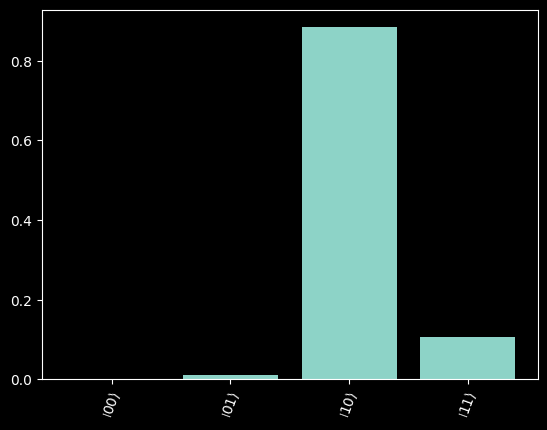

In [85]:
print_output(c)

## Improve the performance with CVaR

Conditional Value-at-Risk (CVaR) is a risk measure that quantifies the potential loss beyond a certain threshold (alpha), considering the tail end of the distribution. As proposed by [Barkoutsos et al. (2020)](https://arxiv.org/abs/1907.04769), incorporating CVaR as an objective function in QAOA allows for addressing risk-averse optimization problems effectively. By optimizing for CVaR, the algorithm focuses on minimizing the expected value of the worst-case scenario, rather than solely optimizing for the mean or expected value, which usually leads to faster convergence to a more accurate result.

To showcase the performance of CVaR, a more complicated QUBO problem is used. This QUBO problem is described as a randomly generated symmetric Q matrix. The Q matrix is:

In [86]:
Q = np.array(
    [
        [-60.3657, 11.68835, 12.23445, 11.7274, 11.9959, 11.80955],
        [11.68835, -59.7527, 11.6231, 13.23295, 11.96335, 12.44725],
        [12.23445, 11.6231, -59.69535, 11.29525, 12.00035, 11.78495],
        [11.7274, 13.23295, 11.29525, -59.12165, 12.1006, 12.5461],
        [11.9959, 11.96335, 12.00035, 12.1006, -60.45515, 12.07545],
        [11.80955, 12.44725, 11.78495, 12.5461, 12.07545, -59.9126],
    ]
)
pauli_terms, weights, offset = QUBO_to_Ising(Q)

Then let's define a function to classically brute-force calculate all feasible combinations of stocks and their associated cost. The results are printed below.

In [87]:
def print_Q_cost(Q, wrap=False, reverse=False):
    n_stocks = len(Q)
    states = []
    for i in range(2**n_stocks):
        a = f"{bin(i)[2:]:0>{n_stocks}}"
        n_ones = 0
        for j in a:
            if j == "1":
                n_ones += 1
        states.append(a)

    cost_dict = {}
    for selection in states:
        x = np.array([int(bit) for bit in selection])
        cost_dict[selection] = np.dot(x, np.dot(Q, x))
    cost_sorted = dict(sorted(cost_dict.items(), key=lambda item: item[1]))
    if reverse == True:
        cost_sorted = dict(
            sorted(cost_dict.items(), key=lambda item: item[1], reverse=True)
        )
    num = 0
    print("\n-------------------------------------")
    print("    selection\t  |\t  cost")
    print("-------------------------------------")
    for k, v in cost_sorted.items():
        print("%10s\t  |\t%.4f" % (k, v))
        num += 1
        if (num >= 8) & (wrap == True):
            break
    print("     ...\t  |\t  ...")
    print("-------------------------------------")


print_Q_cost(Q, wrap=True)


-------------------------------------
    selection	  |	  cost
-------------------------------------
    110010	  |	-109.2784
    100011	  |	-108.9717
    011010	  |	-108.7296
    111000	  |	-108.7219
    101100	  |	-108.6685
    001110	  |	-108.4798
    001011	  |	-108.3416
    101001	  |	-108.3157
     ...	  |	  ...
-------------------------------------


The QAOA with CVaR and three different alpha (1, 0.25, 0.1) will be run and a callback function will be used to record the parameters during the solving procedure. When alpha is $1$, the complete measurement results are accepted and the model changes to the standard QAOA.

In [88]:
# Set the number of layers to 2
nlayers = 2

# Define a list of alpha values
alpha_list = [0.1, 0.25, 1]


# Define the callback function to record parameter values
def record_param(xk):
    xk_list.append(xk)


# Generate initial parameters randomly for all alpha
init_params = K.implicit_randn(shape=[2 * nlayers], stddev=0.5)

# Create an empty list to store parameter values for each alpha
params_list = []

# Iterate over each alpha value
for alpha in alpha_list:
    # Create a new empty list for callback function
    xk_list = []

    # Run the QUBO_QAOA_cvar function with the specified parameters
    final_params = QUBO_QAOA_cvar(
        Q,
        nlayers,
        alpha=alpha,
        callback=record_param,
        maxiter=100,
        init_params=init_params,
    )

    # Append the parameter values for the current alpha to the params_list
    params_list.append(xk_list)

In [89]:
best = 50  # Represents the binary number 110010
prob_list = []  # Create an empty list to store probabilities
loss_list = []  # Create an empty list to store loss values

# Iterate three times
for i in range(3):
    c = QAOA_ansatz_for_Ising(init_params, nlayers, pauli_terms, weights)
    loss = [cvar_loss(nlayers, Q, 1000, alpha_list[i], True, init_params)]
    prob = [c.probability()[best].numpy()]

    # Iterate 100 times
    for j in range(100):
        if j < len(params_list[i]) - 1:
            params = params_list[i][j]
        else:
            pass
        c = QAOA_ansatz_for_Ising(params, nlayers, pauli_terms, weights)
        loss.append(cvar_loss(nlayers, Q, 1000, alpha_list[i], True, params))
        prob.append(c.probability()[best].numpy())

    loss_list.append(loss)  # Append the loss values to the loss_list
    prob_list.append(prob)  # Append the probability values to the prob_list

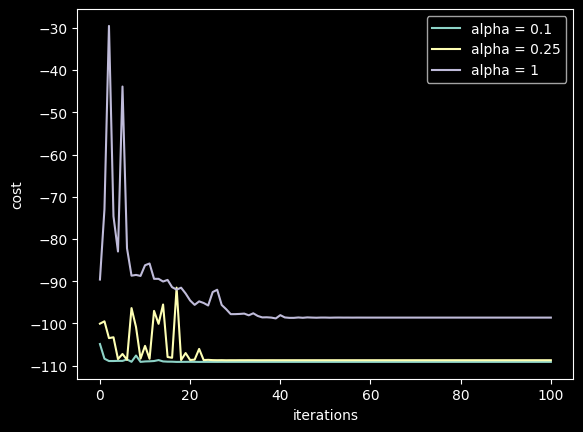

In [92]:
for loss in loss_list:
    plt.plot(loss)
plt.legend(["alpha = 0.1", "alpha = 0.25", "alpha = 1"])
plt.xlabel("iterations")
p = plt.ylabel("cost")

The depicted figure illustrates that utilizing CVaR results in quicker convergence towards a lower loss.

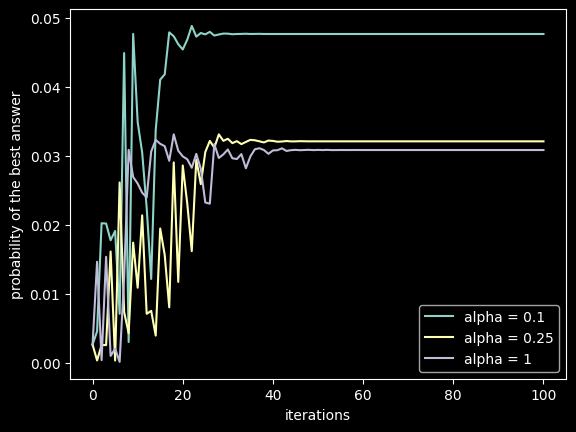

In [93]:
for prob in prob_list:
    plt.plot(prob)
plt.legend(["alpha = 0.1", "alpha = 0.25", "alpha = 1"])
plt.xlabel("iterations")
p = plt.ylabel("probability of the best answer")

The data presented in this figure indicates that QAOA with CVaR typically shows a higher probability of obtaining the correct measurement outcome.